In [105]:
import requests
import re
import nfl_data_py as nfl
import numpy as np
import pandas as pd
import highlight_text as htext
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as path_effects
import matplotlib.font_manager
from PIL import Image
from io import BytesIO

In [2]:
# add font family
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='/home/friend/Downloads/Akzidenz-grotesk-light.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='/home/friend/Downloads/Akzidenz-grotesk-bold.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='/home/friend/Downloads/Akzidenz-grotesk-black.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='/home/friend/Downloads/Akzidenz-grotesk-roman.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Bebas_Neue/BebasNeue-Regular.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Bangers/Bangers-Regular.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Contrail_One/ContrailOne-Regular.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Goldman/Goldman-Regular.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Goldman/Goldman-Bold.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Permanent_Marker/PermanentMarker-Regular.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Righteous/Righteous-Regular.ttf')

In [3]:
# get team to logo URL datframe
team_logoURL = pd.read_csv("./data/team_logos.csv")

In [85]:
team = 'LAC'
season = 2022
week = 2
cols = ['game_id','play_id','epa','season_type','season','week','drive','series','down','ydstogo','wp','ep','yardline_100','home_team','away_team','posteam','defteam','game_seconds_remaining','game_half','fixed_drive_result']#'qb_kneel','field_goal_attempt','TD_team','safety','penalty','fumble_lost','interception','fourth_down_failed']
df_pbp = nfl.import_pbp_data(years=[season], columns=cols, downcast=True, cache=False)
logoURL = team_logoURL[team_logoURL['team_abbr'] == team].team_logo_wikipedia.tolist()[0]
team_nick = team_logoURL[team_logoURL['team_abbr'] == team].team_nick.tolist()[0]

2022 done.
Downcasting floats.


In [87]:
def get_offensive_drives(df, team, week):
    conditional_team = (df['posteam'] == team)
    conditional_week = (df['week'] == week)
    is_down = (df['down'].notnull())
    return df[conditional_team & conditional_week & is_down]

df_team_week_plays = get_offensive_drives(df_pbp, team, week)

In [71]:
def get_teams(df):
    """
        return first listed home and away teams
        from list of unique team names in 
        the nflreadr play by play dataframe
    """
    home_team = df.home_team.unique()[0]
    away_team = df.away_team.unique()[0]
    return home_team, away_team

def get_team_info(df, team):
    """
        return URLs specific to the team
        from nflreadr teams dataframe
    """
    teamname = df[df['team_abbr'] == team].team_name.tolist()[0]
    wordmarkURL = df[df['team_abbr'] == team].team_wordmark.tolist()[0]
    team_color1 = df[df['team_abbr'] == team].team_color.tolist()[0]
    team_color2 = df[df['team_abbr'] == team].team_color2.tolist()[0]
    team_color3 = df[df['team_abbr'] == team].team_color3.tolist()[0]
    return teamname, wordmarkURL, [team_color1, team_color2, team_color3]
    
home_team, away_team = get_teams(df_team_week_plays)

home_teamname, home_wordmarkURL, home_teamcolors = get_team_info(team_logoURL, home_team)
away_teamname, away_wordmarkURL, away_teamcolors = get_team_info(team_logoURL, away_team)

In [72]:
srs_team_weeks_sums = df_team_week_plays.groupby(['drive']).agg({'epa':'sum','ep':'sum','posteam':'count'})
(srs_team_weeks_sums.ep/srs_team_weeks_sums.posteam).sum(axis=0)

16.401554189134302

In [73]:
home_team_wordmark = team_logoURL[team_logoURL['team_abbr'] == home_team].team_color.tolist()[0]

df_drives_results_halfs = df_team_week_plays[['drive','fixed_drive_result','game_half']].drop_duplicates(['drive','fixed_drive_result'])
drives = df_drives_results_halfs['drive'].tolist()
drives_idxs = np.arange(1,len(drives)+1).tolist()
results = df_drives_results_halfs['fixed_drive_result'].tolist()
height_ratios=[1]*(len(drives))

game_halfs = df_drives_results_halfs['game_half'].tolist()
half_idx = game_halfs.index('Half2')
game_halfs.insert(half_idx, '[  halftime  ]')
drives.insert(half_idx, -1)
drives_idxs.insert(half_idx, -1)
results.insert(half_idx, '')
height_ratios.insert(half_idx,0.1)

try:
    overtime_idx = game_halfs.index('Overtime')
    game_halfs.insert(overtime_idx, '[  overtime  ]')
    drives.insert(overtime_idx, -1)
    drives_idxs.insert(overtime_idx, -1)
    results.insert(overtime_idx, '')
    height_ratios.insert(overtime_idx,0.1)
except ValueError:
    print("no overtime period drives detected in this game")

league_epa_min =df_pbp.epa.min()
league_epa_max =df_pbp.epa.max()
game_epa_min =df_team_week_plays.epa.min()
game_epa_max =df_team_week_plays.epa.max()

no overtime period drives detected in this game


In [74]:
drives

[2.0, 4.0, 6.0, 8.0, 10.0, -1, 11.0, 13.0, 15.0, 17.0, 18.0, 20.0, 22.0]

In [75]:
def format_drive_result(drive_result):  
    if drive_result in ["Touchdown", "Opp touchdown"]:
        drive_result = drive_result + "!"
    return " " + drive_result.upper()
    

In [76]:
# adjust coloring of downs?
# How do I want to convey personnel, down and distance, results of drive?

# FONT FAMILY
azkidenz_text = "AkzidenzGrotesk"
bebas_text =  "Bebas Neue"
loma_text = "Loma"
bangers_text = "Bangers"
contrail_text = "Contrail One"
goldman_text = "Goldman"
pm_text = "Permanent Marker"
righteous_text = "Righteous"
ubuntuc_text = "Ubuntu Condensed"
padaukb_text = "Padauk Book"

# ASSIGN FONT FAMILY
title_text = bebas_text
subtitle_text = padaukb_text #ubuntuc_text
axs_label_text = contrail_text
axs_title_text = bebas_text
touchdown_text = bangers_text
drive_result_text = contrail_text
credits_text = pm_text

# COLOR
background = "#343434"#"#444148"
text_color = "#F8F9F9"
filler_color = "grey"
drive_start_color = "lightgrey"
drive_end_color = "lightgrey"
# touchdown_color = "#CFF3F2"
color_map = "Spectral"
mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color

# TEXT
title = "Quicklook:  {}' Offensive Drives\n<NFL {} WEEK {}>    <{}> <@> <{}>"
drive_title = "drive no.{}"
# subtitle = "NFL {} WEEK {}    <{}> <@> <{}>"
credits = "created: keegan heilman / @keeganheilman\ndata: nflreadr (https://github.com/nflverse) via nfl_data_py (https://github.com/cooperdff/nfl_data_py)"

13 28


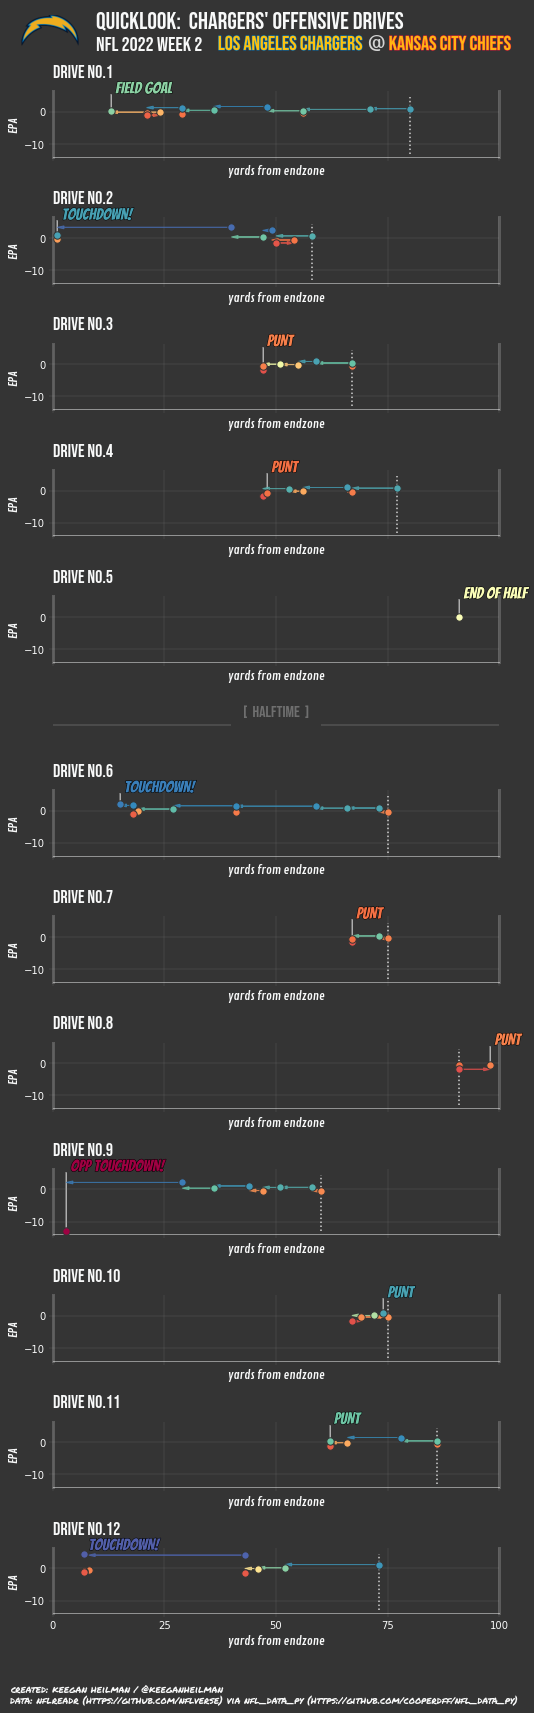

In [101]:
# plot figure, axs

fig_height = round(24/11*len(drives))

print(len(drives),fig_height)

fig = plt.figure(figsize=(8,fig_height))
gs = fig.add_gridspec(len(drives), hspace=1, height_ratios=height_ratios)
# gs = fig.add_gridspec(len(drives),2, hspace=1, height_ratios=height_ratios, width_ratios=[2,1])
# fig.subplots_adjust(wspace=0.1)
axs = gs.subplots(sharex=True, sharey=True)
fig.set_facecolor(background)

cmap = matplotlib.cm.get_cmap(color_map)
norm = mpl.colors.SymLogNorm(linthresh=0.1, vmin=league_epa_min, vmax=league_epa_max)

for axs_idx, (drive, drive_idx, drive_result, game_half) in enumerate(zip(drives, drives_idxs, results, game_halfs)):
    if game_half in ['[  halftime  ]','[  overtime  ]']:
        axs[axs_idx].patch.set_facecolor(background)
        axs[axs_idx].set_title(label=game_half, color=text_color, fontweight="light", fontfamily=axs_title_text, fontsize=16, alpha=0.3)
        axs[axs_idx].axis("off")
        axs[axs_idx].hlines(y=[-1], xmin=0, xmax=40, colors=[drive_start_color],linestyles="solid", alpha=0.2)
        axs[axs_idx].hlines(y=[-1], xmin=60, xmax=100, colors=[drive_start_color],linestyles="solid", alpha=0.2)
    else:
        x = df_team_week_plays[df_team_week_plays.drive == drive].yardline_100.tolist()
        y = df_team_week_plays[df_team_week_plays.drive == drive].epa.tolist()
        axs[axs_idx].patch.set_facecolor(background)
        axs[axs_idx].grid(ls="-", lw=0.2, color="#838383", zorder=-10)
        axs[axs_idx].set_title(drive_title.format(drive_idx),pad=14,loc="left", color=text_color, fontweight="light", fontfamily=axs_title_text, fontsize=18)
        axs[axs_idx].set_xlim(0,100)
        axs[axs_idx].set_xlabel("yards from endzone",color=text_color,fontfamily=axs_label_text, fontsize=12)
        axs[axs_idx].set_ylabel("EPA",color=text_color,fontfamily=axs_label_text, fontsize=12)
        axs[axs_idx].tick_params(axis="both",length=4, width=0.2, color="#838383")
        axs[axs_idx].xaxis.set_major_locator(plt.MaxNLocator(4))
      
        spines = ["top", "right", "bottom", "left"]
        for s in spines:
            if s in ["top"]:
                axs[axs_idx].spines[s].set_visible(False)
            elif s in ["left", "right"]:
                axs[axs_idx].spines[s].set_color(text_color)
                axs[axs_idx].spines[s].set_linewidth(3)
                axs[axs_idx].spines[s].set_alpha(.2)
            else:
                axs[axs_idx].spines[s].set_color(text_color)
                axs[axs_idx].spines[s].set_alpha(.6)



        for point_idx, (x_val, y_val) in enumerate(zip(x,y)):
            cmap_point_color = (cmap(norm(y_val)))
            if point_idx < len(x)-1:
                if point_idx == 0:
                    axs[axs_idx].vlines(x_val, ymin=game_epa_min, ymax=game_epa_max, colors=[drive_start_color], linestyles="dotted")
                axs[axs_idx].arrow(x_val,y_val,
                                     x[point_idx+1]-x_val,0,
                                     color=(cmap(norm(y[point_idx]))),
                                     shape="full",
                                     length_includes_head=True,
                                     head_width=0.9,
                                     head_length=1.5,
                                     capstyle="butt",
                                     alpha=0.8,
                                     lw=1,
                                     zorder=5)
            # plot end of drive information
            if point_idx == len(x)-1:
                # plot vertical line at end of drive point
                end_of_drive_line = axs[axs_idx].vlines(x_val, ymin=y_val,ymax=game_epa_max+1,
                                                          colors=[drive_end_color],
                                                          linestyles="solid",
                                                          alpha=0.5,
                                                          zorder=-5)
                end_of_drive_line.set_path_effects([path_effects.withStroke(linewidth=0.5, foreground="white")])
                # plot end of drive result text (e.g. "TOUCHDOWN!") 
                drive_result_t= axs[axs_idx].text(x=x_val+0.3,y=game_epa_max+1.2,
                                                        s=format_drive_result(drive_result),
                                                        color=cmap_point_color,
                                                        fontfamily=touchdown_text,
                                                        fontsize=16)
                drive_result_t.set_path_effects([path_effects.withStroke(linewidth=1, foreground="black")])
            # plot play point x=epa, y=yardline_100
            axs[axs_idx].scatter(x_val,y_val, color=cmap_point_color,edgecolors=background,s=55, alpha=1,lw=1,zorder=10)

        
# plot figure title
title_t = htext.fig_text(s=title.format(team_nick, season, week, away_teamname, home_teamname),
               x=0.2,y=0.92,
               highlight_textprops=[{"fontsize":20, "color": text_color},
                                    {"fontsize":20, "color": away_teamcolors[1], "path_effects":[path_effects.withStroke(linewidth=1, foreground=away_teamcolors[0])]},
                                    {"fontsize":20, "color": "lightgrey", "fontfamily":subtitle_text},
                                    {"fontsize":20, "color": home_teamcolors[1], "path_effects":[path_effects.withStroke(linewidth=1, foreground=home_teamcolors[0])]}],
               color=text_color,
               fontsize=24,
               fontfamily=title_text)


# add axis and plot logo
ax2 = fig.add_axes([0.07,0.86,0.10,0.10])
ax2.axis("off")
url = logoURL
response = requests.get(url)
img = Image.open(BytesIO(response.content))
ax2.imshow(img)
             
# plot credits
fig.text(0.05, 0.08,
         s=credits,
         fontstyle="italic",
         fontweight="light",
         fontsize=10,
         fontfamily=credits_text,
         color=text_color)
    

plt.show()
fig.savefig(f'{season}-WEEK{week}-{team}.png',bbox_inches='tight', dpi=300)
# plt.close('all')

In [78]:
# # confirm font family is added
# from IPython.core.display import HTML
# def make_html(fontname):
#     return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

# code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

# HTML("<div style='column-count: 2;'>{}</div>".format(code))

In [80]:
df_par = pd.read_csv(f'data/pbp_participation_{season}.csv')
df_par

,nflverse_game_id,old_game_id,play_id,possession_team,offense_formation,offense_personnel,defenders_in_box,defense_personnel,number_of_pass_rushers,players_on_play,offense_players,defense_players,n_offense,n_defense
0,2022_01_BUF_LA,2022090800,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,2022_01_BUF_LA,2022090800,41,LA,NaN,NaN,NaN,NaN,NaN,52512;42818;48482;52835;48772;54696;48011;5284...,00-0036421;00-0035933;00-0035609;00-0035942;00...,00-0031787;00-0035352;00-0037318;00-0035308;00...,11,11
2,2022_01_BUF_LA,2022090800,56,BUF,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"3 DL, 3 LB, 5 DB",4.0,42816;48512;43298;47844;43335;47879;44875;4791...,00-0035382;00-0035689;00-0033904;00-0027648;00...,00-0031785;00-0033072;00-0035663;00-0032889;00...,11,11
3,2022_01_BUF_LA,2022090800,80,BUF,EMPTY,"1 RB, 1 TE, 3 WR",6.0,"3 DL, 3 LB, 5 DB",NaN,42816;48512;43298;47844;43335;47879;44875;4791...,00-0035382;00-0035689;00-0033904;00-0027648;00...,00-0031785;00-0033072;00-0035663;00-0032889;00...,11,11
4,2022_01_BUF_LA,2022090800,101,BUF,I_FORM,"2 RB, 1 TE, 2 WR",6.0,"3 DL, 3 LB, 5 DB",NaN,42816;48512;42818;43298;47939;47844;43335;4787...,00-0035382;00-0031787;00-0035689;00-0033904;00...,00-0031785;00-0033072;00-0035591;00-0035663;00...,11,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5848,2022_03_PIT_CLE,2022092200,4098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
5849,2022_03_PIT_CLE,2022092200,4156,CLE,NaN,NaN,NaN,NaN,NaN,47905;54915;44903;43400;53897;46698;53674;5297...,00-0037332;00-0033927;00-0036692;00-0029008;00...,00-0035217;00-0032399;00-0034514;00-0036846;00...,11,11
5850,2022_03_PIT_CLE,2022092200,4169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
5851,2022_03_PIT_CLE,2022092200,4183,PIT,SHOTGUN,"1 RB, 1 TE, 3 WR",2.0,"1 DL, 3 LB, 7 DB",2.0,54915;52452;54533;44903;52457;47849;48588;5348...,00-0036326;00-0035216;00-0036894;00-0036893;00...,00-0037332;00-0036282;00-0037250;00-0033927;00...,11,11


In [102]:
def merge_play_par(df_play, df_par):
    return pd.merge(df_play, df_par, how='left', left_on=['game_id','play_id'], right_on=['nflverse_game_id','play_id'])

df_play_par = merge_play_par(df_team_week_plays, df_par)

In [180]:
def extract_personnel(pers):
    re_SP_pattern = re.compile('(SP)')
    re_OL_pattern = re.compile('(\d) OL')
    re_RB_pattern = re.compile('(\d) RB')
    re_TE_pattern = re.compile('(\d) TE')
    re_WR_pattern = re.compile('(\d) WR')
    return {'SP':re_SP_pattern.findall(pers)[0] if len(re_SP_pattern.findall(pers)) == 1 else '0',
           'OL':re_OL_pattern.findall(pers)[0] if len(re_OL_pattern.findall(pers)) == 1 else '0',
           'RB':re_RB_pattern.findall(pers)[0] if len(re_RB_pattern.findall(pers)) == 1 else '0',
           'TE':re_TE_pattern.findall(pers)[0] if len(re_TE_pattern.findall(pers)) == 1 else '0',
           'WR':re_WR_pattern.findall(pers)[0] if len(re_WR_pattern.findall(pers)) == 1 else '0'}

df_play_par.loc[df_play_par['offense_personnel'].isnull(), 'offense_personnel'] = 'SP'
df_play_par.merge(pd.DataFrame.from_records(df_play_par['offense_personnel'].apply(extract_personnel)), how='left', left_index=True, right_index=True)

,game_id,play_id,epa,season_type,week,drive,series,down,ydstogo,wp,...,players_on_play,offense_players,defense_players,n_offense,n_defense,SP,OL,RB,TE,WR
0,2022_02_LAC_KC,233.0,0.940955,REG,2,2.0,4.0,1.0,10.0,0.482290,...,46144;47874;52546;53442;53506;45573;47846;4240...,00-0035688;00-0037009;00-0036988;00-0033699;00...,00-0034818;00-0036374;00-0035625;00-0032210;00...,11,11,0,0,1,1,3
1,2022_02_LAC_KC,257.0,0.701622,REG,2,2.0,4.0,2.0,1.0,0.496895,...,46144;47874;52546;53442;53506;45573;47846;4240...,00-0035688;00-0037009;00-0036988;00-0033699;00...,00-0034818;00-0036374;00-0035625;00-0032210;00...,11,11,0,0,1,2,2
2,2022_02_LAC_KC,281.0,-0.491218,REG,2,2.0,5.0,1.0,10.0,0.529993,...,46144;52546;53442;47874;53506;45573;47846;4240...,00-0037009;00-0035688;00-0036988;00-0033699;00...,00-0034818;00-0036374;00-0035625;00-0032210;00...,11,11,0,0,1,2,2
3,2022_02_LAC_KC,303.0,0.289636,REG,2,2.0,5.0,2.0,10.0,0.514347,...,46144;47874;52546;53442;53506;45573;42406;4784...,00-0035688;00-0037009;00-0036988;00-0033699;00...,00-0034818;00-0036374;00-0032210;00-0035625;00...,11,11,0,0,1,2,2
4,2022_02_LAC_KC,324.0,1.608781,REG,2,2.0,5.0,3.0,2.0,0.513974,...,47874;52546;53442;53506;45573;42406;47846;4195...,00-0035688;00-0037009;00-0036988;00-0033699;00...,00-0036374;00-0032210;00-0035625;00-0036378;00...,11,11,0,0,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,2022_02_LAC_KC,3879.0,4.100690,REG,2,22.0,51.0,4.0,1.0,0.026191,...,53442;52546;53506;47846;42406;41959;52520;4631...,00-0037009;00-0036988;00-0031142;00-0036370;00...,00-0036374;00-0035625;00-0032210;00-0036621;00...,11,11,0,0,1,1,3
79,2022_02_LAC_KC,3903.0,-0.476716,REG,2,22.0,52.0,1.0,8.0,0.054538,...,52546;53442;53506;45573;47846;42406;41959;4631...,00-0037009;00-0036988;00-0033699;00-0031142;00...,00-0036374;00-0035625;00-0032210;00-0036621;00...,11,11,0,0,1,1,3
80,2022_02_LAC_KC,3939.0,-0.725876,REG,2,22.0,52.0,2.0,7.0,0.051204,...,52546;53442;53506;45573;47846;42406;41959;4631...,00-0037009;00-0036988;00-0033699;00-0031142;00...,00-0036374;00-0035625;00-0032210;00-0036621;00...,11,11,0,0,1,1,3
81,2022_02_LAC_KC,3966.0,-1.282093,REG,2,22.0,52.0,3.0,7.0,0.043731,...,52546;53442;53506;45573;47846;42406;41959;4631...,00-0037009;00-0036988;00-0033699;00-0031142;00...,00-0036374;00-0035625;00-0032210;00-0036621;00...,11,11,0,0,1,1,3
